<a href="https://colab.research.google.com/github/Chygos/deeplearning/blob/main/crop_seedling_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 1. Importing Necessary Libraries

In [1]:
from google.colab import files, drive

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd drive/My Drive/crop_seedling_classification

/content/drive/My Drive/crop_seedling_classification


In [4]:
# ignoring warnings
import os, gc, warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, optimizers, losses
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import random

In [8]:
tf.__version__

'2.5.0'

In [9]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [10]:
# for reproducibility
seed = 483
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

#### Importing Datasets

In [11]:
imgs = np.load('images.npy')
labels = np.genfromtxt('Labels.csv', dtype=None, delimiter='\n', encoding='utf-8', skip_header=1)

Shape of Dataset

In [12]:
print(imgs.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750,)


The dataset contains 4,750 images with each image having dimensions of 128 (height) by 128 (width) in 3 channels (RGB)

#### Visualizing Images

In [13]:
print(f'There are {len(np.unique(labels))} unique labels')

There are 12 unique labels


In [14]:
print(np.unique(labels))

['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']


In [15]:
img_types = np.unique(labels)
label_df = pd.Series(labels)

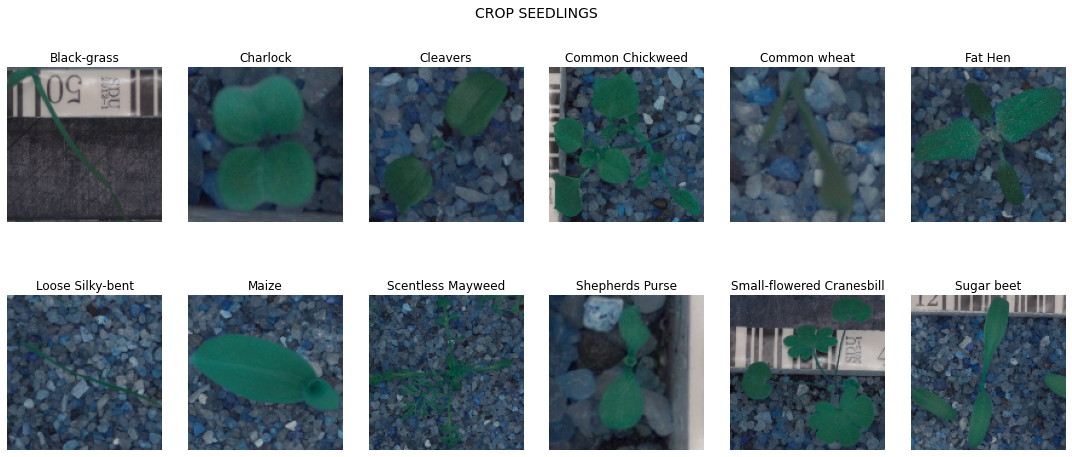

In [16]:
plt.figure(figsize=(15,7))
for i in range(len(img_types)):
    name = img_types[i] # get name
    idx = label_df[label_df == name].sample(1, random_state=61).index[0] # get index of sampled crop type
    img = Image.fromarray(imgs[idx])
    plt.subplot(2,6, i+1)
    plt.title(name)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Crop Seedlings'.upper(), y=1.00, fontsize=14)
plt.tight_layout(w_pad=0.9);

#### 2. DATA PREPROCESSING

##### a. Normalization: To normalize, we will divide by the max pixel values (255)

In [17]:
imgs = imgs.astype('float32')

In [18]:
imgs /= 255.

##### b. Gaussian Blurring (3x3 kernel size and 1-sigma values at x- and y- directions)

In [19]:
for i in range(len(imgs)):
    imgs[i] = cv2.GaussianBlur(imgs[i], ksize=(3, 3), sigmaX=1, sigmaY=1)

#### c. Visualizing blurred Images

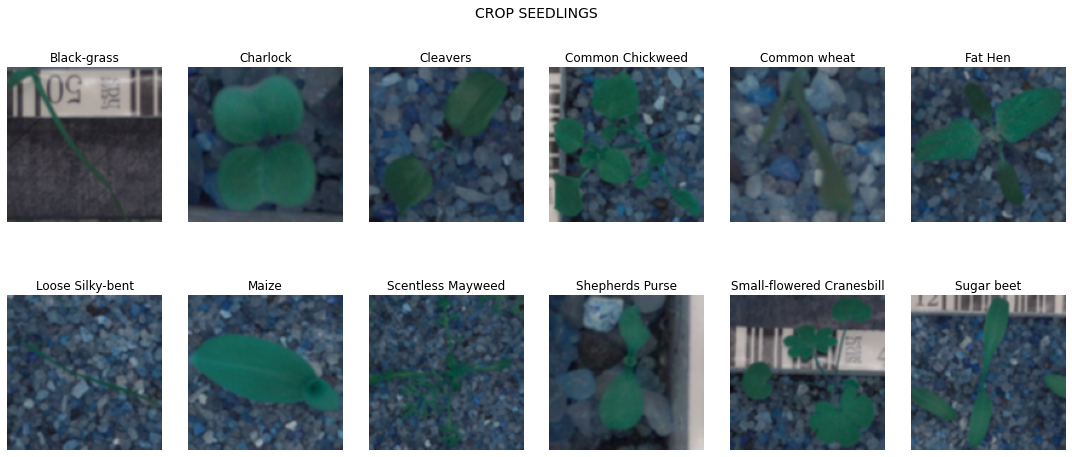

In [20]:
plt.figure(figsize=(15,7))
for i in range(len(img_types)):
    name = img_types[i] # get name
    idx = label_df[label_df == name].sample(1, random_state=61).index[0] # get index of sampled crop type
    
    plt.subplot(2,6, i+1)
    plt.title(name)
    plt.imshow(imgs[idx])
    plt.axis("off")
plt.suptitle('Crop Seedlings'.upper(), y=1.00, fontsize=14)
plt.tight_layout(w_pad=0.9);

#### 3. Making Data Compatible

#### a. Converting Labels to One-hot-vectors

In [21]:
label_2_idx = {j:i for i, j in zip(range(len(np.unique(labels))), np.unique(labels))}

In [22]:
num_classes= len(np.unique(labels))

In [23]:
label_idx = pd.Series(labels).map(label_2_idx).values.astype('int32')

In [24]:
ytrain = to_categorical(label_idx, num_classes=num_classes)

In [25]:
# printing label for y_train[0]
print(ytrain[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


#### c. Splitting into training, testing and validation sets

To have an evenly distribution of classes, we will use the stratify argument in train_test_split function.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(imgs, label_idx, test_size=0.3, 
                                                    random_state=seed, stratify=label_idx)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, 
                                                random_state=seed, stratify=y_test)

In [27]:
# One hot encoding y_train, y_test and y_valid
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [28]:
X_train.shape, X_test.shape, X_val.shape

((3325, 128, 128, 3), (712, 128, 128, 3), (713, 128, 128, 3))

The data is compatible for a CNN model as CNNs for image classification require the input to have a 3-dimensional spatial structure. That is the height, width and the number of channels, in this case 3, representing RGB images

### CNN Model Architecture

In [29]:
input_shape = X_train.shape[1:]

def create_model(input_shape):
    # input layers
    model = Sequential(name='CNN_Model')
    
    model.add(Conv2D(32, kernel_size=5, padding='valid', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=3, padding='valid', activation='relu'))
    model.add(Conv2D(64, kernel_size=3, padding='valid', activation='relu'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Dropout(0.25))
    
    model.add(Conv2D(128, kernel_size=3, padding='valid', activation='relu'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Dropout(0.25))

    model.add(Conv2D(256, kernel_size=3, padding='valid', activation='relu'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.Dropout(0.5))

    # output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [30]:
model = create_model(input_shape)
model.summary()

Model: "CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 29, 64)        0 

In [31]:
checkpoint = ModelCheckpoint('crop_seedling_classification.h5', save_best_only=True)
earlystop = EarlyStopping(monitor='val_acc', patience=10)

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [33]:
batch_size = 64

In [34]:
history = model.fit(X_train,y_train, epochs=100, shuffle=True, verbose=1, batch_size=batch_size,
                    validation_data=(X_val, y_val) ,callbacks=[checkpoint, earlystop]);

Epoch 1/100
52/52 [==============================] - 36s 80ms/step - loss: 2.4289 - acc: 0.1459 - val_loss: 2.2802 - val_acc: 0.2889
Epoch 2/100
52/52 [==============================] - 3s 57ms/step - loss: 1.8899 - acc: 0.3507 - val_loss: 1.7092 - val_acc: 0.4067
Epoch 3/100
52/52 [==============================] - 3s 58ms/step - loss: 1.6344 - acc: 0.4244 - val_loss: 1.6179 - val_acc: 0.4404
Epoch 4/100
52/52 [==============================] - 3s 57ms/step - loss: 1.4401 - acc: 0.5167 - val_loss: 1.2460 - val_acc: 0.5708
Epoch 5/100
52/52 [==============================] - 3s 58ms/step - loss: 1.2564 - acc: 0.5576 - val_loss: 1.3179 - val_acc: 0.5316
Epoch 6/100
52/52 [==============================] - 3s 58ms/step - loss: 1.1169 - acc: 0.6075 - val_loss: 1.0081 - val_acc: 0.6536
Epoch 7/100
52/52 [==============================] - 3s 58ms/step - loss: 1.0119 - acc: 0.6577 - val_loss: 0.9157 - val_acc: 0.6872
Epoch 8/100
52/52 [==============================] - 3s 58ms/step - loss: 0

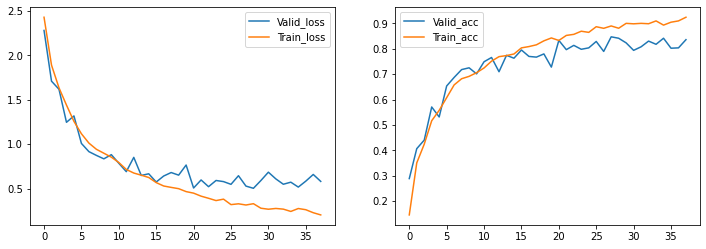

In [35]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(history.history['val_loss'], label='Valid_loss')
ax[0].plot(history.history['loss'], label='Train_loss')

ax[1].plot(history.history['val_acc'], label='Valid_acc')
ax[1].plot(history.history['acc'], label='Train_acc')

ax[0].legend()
ax[1].legend()
plt.subplots_adjust(wspace=0.2);

In [36]:
val_predictions = model.predict(X_val)

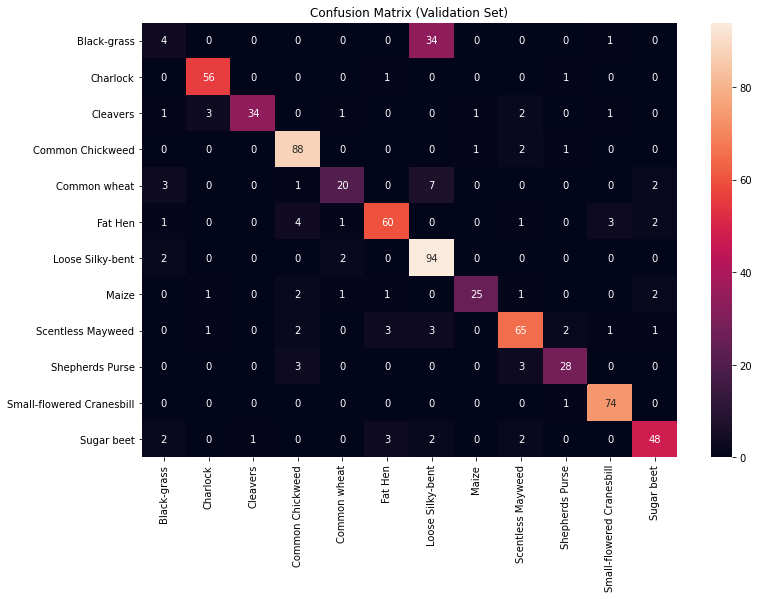

In [37]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_val.argmax(1), val_predictions.argmax(1)), 
            yticklabels=img_types, xticklabels=img_types, annot=True)
plt.title('Confusion Matrix (Validation Set)');

#### Test Evaluations

In [38]:
test_predictions = model.predict(X_test)

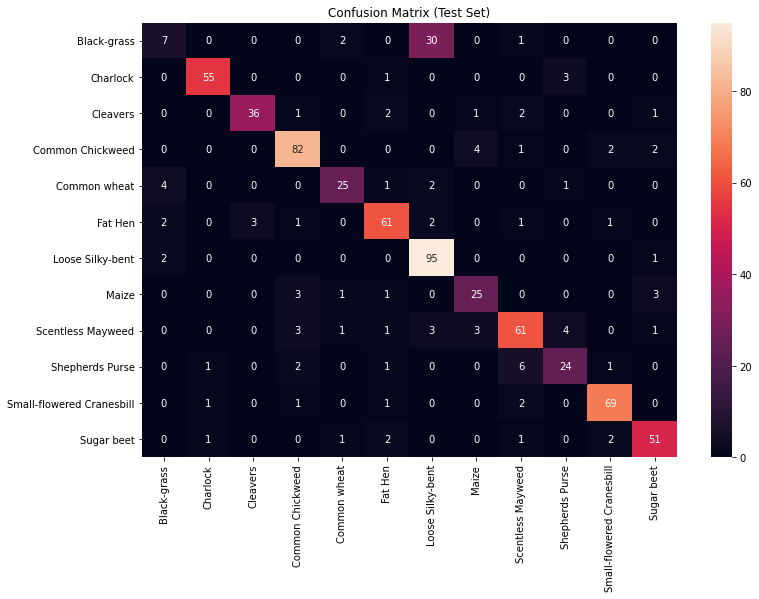

In [39]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(y_test.argmax(1), test_predictions.argmax(1)), yticklabels=img_types, 
            xticklabels=img_types, annot=True)
plt.title('Confusion Matrix (Test Set)');

#### 6: Visualize Predictions X_test[2], X_test[3], X_test[33], X_test[36], X_test[59]

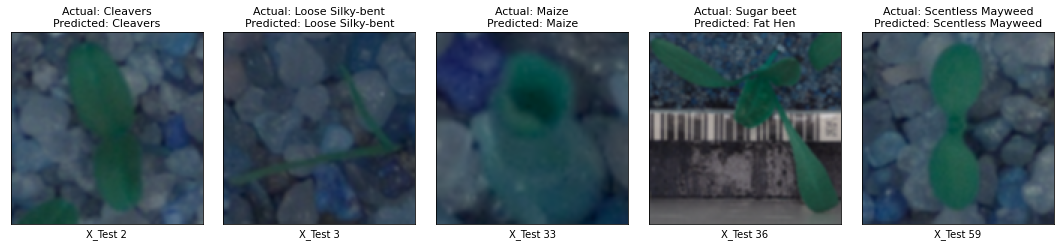

In [40]:
plt.figure(figsize=(15,4))
for i, idx in enumerate([2,3,33,36,59]):
  plt.subplot(1,5, i+1)
  plt.imshow(X_test[idx])
  plt.xlabel(f'X_Test {idx}')
  plt.yticks([])
  plt.xticks([])
  plt.title(f'Actual: {img_types[y_test[idx].argmax()]}\nPredicted: {img_types[test_predictions[idx].argmax()]}', fontsize=11)
plt.tight_layout(w_pad=0.9);

In [43]:
%%shell
jupyter nbconvert --to html /content/crop_seedling_classification_main.ipynb

[NbConvertApp] Converting notebook /content/crop_seedling_classification_main.ipynb to html
[NbConvertApp] Writing 2088735 bytes to /content/crop_seedling_classification_main.html
